## Fitting dynamical models with priors which are conditioned on functional anchors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import math

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import torch

from janelia_core.ml.torch_distributions import CondBernoulliDistribution
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondLowRankMatrixDistribution
from janelia_core.ml.torch_distributions import CondSpikeSlabDistribution
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.extra_torch_modules import LogGaussianBumpFcn

from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Parameters go here

In [3]:
n_neurons = 1000
n_modes = 2
n_smps = 1000
neural_noise_std = .5 # Amount of noise we add to neural activity

## Here we define functions for visualization

In [4]:
def visualize_mode_mean(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
           y_range[0]:y_range[1]:n_points_per_side * 1j]

    grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))

    mn_vec = d(grid_vec).detach().numpy()
    mn_image = np.reshape(mn_vec, [n_points_per_side, n_points_per_side])
    
    plt.imshow(mn_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
    plt.colorbar()
    
def visualize_low_rank_matrix_modes(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
    
    l_dists = d.l_mode_dists
    r_dists = d.r_mode_dists
    
    n_modes = len(l_dists)
    
    plt.figure()
    
    for m_i in range(n_modes):
        
        # Plot r modes in top row
        plt.subplot(2, n_modes, m_i+1)
        visualize_mode_mean(r_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        
        # Plot l modes in second row
        plt.subplot(2, n_modes, m_i+1 + n_modes)
        visualize_mode_mean(l_dists[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        

## Define the likelihood model we will use

In [5]:
class SubjectModel(torch.nn.Module):
    
    def __init__(self, d_x:int):
        """ Creates a SubjectModel object.
        
        Args:
            n: the dimensionality of x (which is the data we predict from)
        """
        
        super().__init__()
         
        self.d_x = d_x
        self.std = ConstantBoundedFcn(lower_bound=.01*np.ones(d_x), upper_bound=5*np.ones(d_x), init_value=np.ones(d_x))
        
    def forward(self, x: torch.Tensor, w: torch.Tensor):
        
        return cond_mn(x, w)
        
    def cond_mn(self, x: torch.Tensor, w: torch.Tensor):
        """ Computes mean given x and w.
        
        Args:
            x: neural data of shape n_smps*d_x
            
            w: weight matrix of shape d_y*d_x
            
        Returns:
            mn: mean of shape n_smps*d_y
        
        """
        return torch.matmul(x, w.t())
    
    def cond_ll(self, x: torch.Tensor, y: torch.Tensor, w: torch.Tensor):
        """ Computes conditional likelihood of y, given x and w.
        
        Args:
            x: neural data to condition on of shape n_smps*d_x
            
            y: neural data to predict of shape n_smps*d_y
            
            w: weight matrix of shape d_y*d_x
            
        Returns:
            ll: conditional likelihood of each sample, of shape n_smps
        """
        
        if len(x.shape) == 1:
            raise(NotImplementedError('Code has not been tested with a single sample. May need to check that it still computes correctly.'))
        
        d_y = y.shape[1]
        
        mn = self.cond_mn(x, w)
        std = self.std(mn)
           
        delta = y - mn
        delta_div = delta/std
        dist_sq = torch.sum(delta_div**2,1)
        
        
        ll = -.5*dist_sq
        ll -= torch.sum(torch.log(std), 1)
        ll -= .5*d_y*torch.log(2*torch.tensor([math.pi]))
        
        return ll

## Generate neuron properties

In [6]:
neuron_props = torch.zeros(n_neurons, 2).uniform_()

## Define true conditional prior on weights matrix

In [7]:
# Spike and slab modes

n_nodes = 20

p_l_mode_dists = [None]*n_modes
p_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    p_l_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=0.25,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.000001)
    p_l_spike_d = CondBernoulliDistribution(p_l_spike_log_prob_fcn)

    p_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_l_slab_mn_fcn[4].weight.data = 10*p_l_slab_mn_fcn[4].weight.data

    p_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_l_slab_d = CondGaussianDistribution(mn_f=p_l_slab_mn_fcn, std_f=p_l_slab_std_fcn)


    p_l_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_l_spike_d, slab_d=p_l_slab_d)
    
    
    # Setup r mode 
    p_r_spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_lb=.02, ctr_std_ub=20000.0, ctr_std_init=0.25,
                                   log_gain_lb=-10.0, log_gain_ub=0.0, log_gain_init=-0.0000001)
    p_r_spike_d = CondBernoulliDistribution(p_r_spike_log_prob_fcn)

    p_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_r_slab_mn_fcn[4].weight.data = 10*p_r_slab_mn_fcn[4].weight.data

    p_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_r_slab_d = CondGaussianDistribution(mn_f=p_r_slab_mn_fcn, std_f=p_r_slab_std_fcn)


    p_r_mode_dists[m_i] = CondSpikeSlabDistribution(d=1, spike_d=p_r_spike_d, slab_d=p_r_slab_d)
    

p = CondLowRankMatrixDistribution(l_mode_dists=p_l_mode_dists, r_mode_dists=p_r_mode_dists)

## Sample from prior on weight matrix to get true modes of the weight matrix for the subject

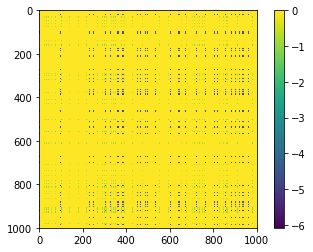

In [8]:
with torch.no_grad():
    smp = p.sample(neuron_props, neuron_props)
    w_true = p.form_matrix(smp)
    
# Show the true weight matrix
plt.imshow(w_true.detach())
plt.colorbar()

## Generate neural activity

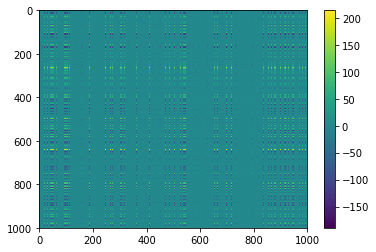

In [9]:
with torch.no_grad():
    x = torch.randn([n_smps, n_neurons])
    y_mn = torch.matmul(x, w_true.t())
    y_noise = torch.randn([n_smps, n_neurons])*neural_noise_std
    y = y_mn + y_noise
    
plt.imshow(y, aspect='auto')
plt.colorbar()

## Initialize conditional prior on weights matrix we will fit

## Define p we use for fitting

In [10]:
# Spike and slab modes

n_nodes = 100

p_f_l_mode_dists = [None]*n_modes
p_f_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    p_f_l_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_f_l_slab_mn_fcn[4].weight.data = 10*p_f_l_slab_mn_fcn[4].weight.data

    p_f_l_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_f_l_slab_d = CondGaussianDistribution(mn_f=p_f_l_slab_mn_fcn, std_f=p_f_l_slab_std_fcn)


    p_f_l_mode_dists[m_i] = p_f_l_slab_d
    
    
    # Setup r mode 
    p_f_r_slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_nodes), torch.nn.ReLU(), torch.nn.Linear(n_nodes, n_nodes), 
                                          torch.nn.ReLU(), torch.nn.Linear(n_nodes,1))
    p_f_r_slab_mn_fcn[4].weight.data = 10*p_f_r_slab_mn_fcn[4].weight.data

    p_f_r_slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))

    p_f_r_slab_d = CondGaussianDistribution(mn_f=p_f_r_slab_mn_fcn, std_f=p_f_r_slab_std_fcn)


    p_f_r_mode_dists[m_i] = p_f_r_slab_d

p_f = CondLowRankMatrixDistribution(l_mode_dists=p_f_l_mode_dists, r_mode_dists=p_f_r_mode_dists)

## Define q we use for fitting

In [11]:
class IndMean(torch.nn.Module):
    def __init__(self, n: int):
        
        super().__init__()
        
        self.n = n
        self.mn = ConstantRealFcn(.01*np.ones(n))
        
    def forward(self, x):
        place_holder_input = torch.zeros(1)
        full_mn = self.mn(place_holder_input).t()
        return full_mn

In [12]:
class IndStd(torch.nn.Module):
    
    def __init__(self, n: int):
        
        super().__init__()
        
        self.n = n
        self.stds = ConstantBoundedFcn(0*np.ones(n), 10*np.ones(n), .1*np.ones(n))
    
    def forward(self, x):
        place_holder_input = torch.zeros(1)
        full_std = self.stds(place_holder_input).t()
        return full_std

In [13]:
# Spike and slab modes

q_l_mode_dists = [None]*n_modes
q_r_mode_dists = [None]*n_modes

for m_i in range(n_modes):
    # Setup l mode
    
    q_l_slab_mn_fcn = IndMean(n_neurons)
    q_l_slab_std_fcn = IndStd(n_neurons)
    
    q_l_slab_d = CondGaussianDistribution(mn_f=q_l_slab_mn_fcn, std_f=q_l_slab_std_fcn)

    q_l_mode_dists[m_i] = q_l_slab_d
    
    # Setup r mode 

    q_r_slab_mn_fcn = IndMean(n_neurons)
    q_r_slab_std_fcn = IndStd(n_neurons)
    
    q_r_slab_d = CondGaussianDistribution(mn_f=q_r_slab_mn_fcn, std_f=q_r_slab_std_fcn)

    q_r_mode_dists[m_i] = q_r_slab_d
    
q = CondLowRankMatrixDistribution(l_mode_dists=q_l_mode_dists, r_mode_dists=q_r_mode_dists)

## Perform fitting

In [14]:
s = SubjectModel(n_neurons)

In [28]:
r_params = list(itertools.chain(s.parameters(), q.r_params(), p_f.r_params(), p_f.s_params()))
r_optim = torch.optim.Adam(r_params, lr=.01)

In [34]:
n_its = 5000
update_int = 100
n_inf_smps = 1

c_l = torch.zeros(n_modes)
c_r = torch.zeros(n_modes)
alpha = .9

for i in range(n_its):
    
    # Sample q
    smp = [q.sample(neuron_props, neuron_props) for j in range(n_inf_smps)]
    w = [q.form_matrix(smp_j) for smp_j in smp]
    
    # Calculate gradients we can use the reparamaterization trick for
    r_optim.zero_grad()
    nlls = torch.zeros(n_inf_smps)
    q_l_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    q_r_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    p_l_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    p_r_mode_log_probs = torch.zeros(n_inf_smps, n_modes)
    
    for j in range(n_inf_smps):
        nlls[j] = -1*torch.sum(s.cond_ll(x, y, w[j]))
        
        q_l_lp, q_r_lp = q.log_prob(neuron_props, neuron_props, smp[j][0], smp[j][1])
        q_l_mode_log_probs[j, :] = torch.sum(q_l_lp, dim=0)
        q_r_mode_log_probs[j, :] = torch.sum(q_r_lp, dim=0)
        
        p_l_lp, p_r_lp = p_f.log_prob(neuron_props, neuron_props, smp[j][0], smp[j][1])
        p_l_mode_log_probs[j, :] = torch.sum(p_l_lp, dim=0)
        p_r_mode_log_probs[j, :] = torch.sum(p_r_lp, dim=0)
        
    neg_elbo = torch.sum(nlls) + torch.sum(q_l_lp) + torch.sum(q_r_lp) - torch.sum(p_l_lp) - torch.sum(p_r_lp)
    
    neg_elbo.backward(retain_graph=False)
    
    # Actually update parameters here
    r_optim.step()
    
    # Update parameters 
    if i % update_int == 0:
        neg_elbo_r = neg_elbo.detach().numpy()
        print('It: ' + str(i) + ', neg_elbo: ' + str(neg_elbo_r))
    

It: 0, neg_elbo: 758820.7
It: 100, neg_elbo: 758609.3
It: 200, neg_elbo: 758959.6
It: 300, neg_elbo: 758901.4
It: 400, neg_elbo: 759044.56
It: 500, neg_elbo: 759110.2
It: 600, neg_elbo: 759313.94
It: 700, neg_elbo: 759365.5
It: 800, neg_elbo: 759674.5
It: 900, neg_elbo: 759063.5
It: 1000, neg_elbo: 758616.94
It: 1100, neg_elbo: 759198.4
It: 1200, neg_elbo: 759221.44
It: 1300, neg_elbo: 759628.06
It: 1400, neg_elbo: 758897.5
It: 1500, neg_elbo: 759003.56
It: 1600, neg_elbo: 759105.8
It: 1700, neg_elbo: 758875.06
It: 1800, neg_elbo: 758488.06
It: 1900, neg_elbo: 758743.25
It: 2000, neg_elbo: 759116.0
It: 2100, neg_elbo: 759353.56


KeyboardInterrupt: 

In [35]:
smp_i = q.sample(neuron_props, neuron_props)
#smp_i = q.sample(neuron_inds, neuron_inds)
w_i = q.form_matrix(smp_i)

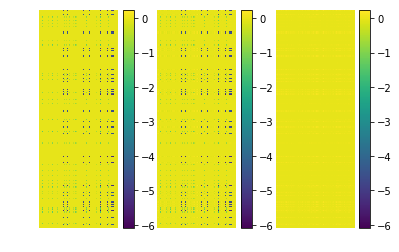

In [36]:
w_n = w_true.detach().numpy()
w_i_n = w_i.detach().numpy()
cmp_n_mats([w_n, w_i_n, np.abs(w_n - w_i_n)], show_colorbars=True)

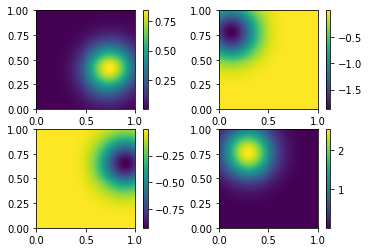

In [37]:
visualize_low_rank_matrix_modes(p)

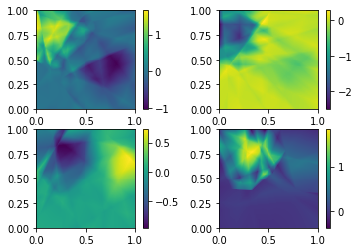

In [38]:
visualize_low_rank_matrix_modes(p_f)

In [21]:
s.std(neuron_props)

tensor([[0.5076, 0.5193, 1.3025,  ..., 0.5002, 0.5019, 0.5061],
        [0.5076, 0.5193, 1.3025,  ..., 0.5002, 0.5019, 0.5061],
        [0.5076, 0.5193, 1.3025,  ..., 0.5002, 0.5019, 0.5061],
        ...,
        [0.5076, 0.5193, 1.3025,  ..., 0.5002, 0.5019, 0.5061],
        [0.5076, 0.5193, 1.3025,  ..., 0.5002, 0.5019, 0.5061],
        [0.5076, 0.5193, 1.3025,  ..., 0.5002, 0.5019, 0.5061]],
       grad_fn=<ExpandBackward>)